In [168]:
import matplotlib.pyplot as plt
import numpy as np 
from scipy.interpolate import RegularGridInterpolator
def integrate_particles(positions, concentrations, velocity_field, X, Y, dt, num_steps, L, phase_field, gamma, r):
    num_particles = len(positions)
    positions_over_time,  concentrations_over_time = np.zeros((num_steps+1, num_particles, 2)), np.zeros((num_steps+1, num_particles, 1))
    positions_over_time[0] = positions
    concentrations_over_time[0] = concentrations
    negpsiy, psix = -1*diff_wrt_y(velocity_field), diff_wrt_x(velocity_field)
    phix, phiy = diff_wrt_x(phase_field), diff_wrt_y(phase_field)
    interpsiy, interphix, interpsix, interphiy = interpolate(negpsiy), interpolate(phix), interpolate(psix), interpolate(phiy)
    t = [i*dt for i in range(num_steps+1)]
    psiyx, psixy = diff_wrt_x(negpsiy), diff_wrt_y(psix)
    phixx, phiyy = diff_wrt_x(phix), diff_wrt_y(phiy)
    interpsiyx, interphixx, interpsixy, interphiyy = interpolate(psiyx), interpolate(phixx), interpolate(psixy), interpolate(phiyy)
    a = [interpsiy, interphix, interpsix, interphiy, interpsiyx, interphixx, interpsixy, interphiyy]
    answer = new_vector_rk4(fun, t, polynomial_u, polynomial_v, positions_over_time, polynomial_du, polynomial_dv, concentrations_over_time, num_particles, a)
    return answer

def polynomial_u(coords, a):
    interpsiy, interphix = a[0], a[1]
    return np.real((1-gamma)*interpsiy(coords)+gamma*interphix(coords))

def polynomial_v(coords, a):
    #print(coords)
    interpsix, interphiy = a[2], a[3]
    return np.real((1-gamma)*interpsix(coords)+gamma*interphiy(coords))

def polynomial_du(coords, a):
    interpsiyx, interphixx = a[4], a[5]
    return np.real((1-gamma)*interpsiyx(coords)+gamma*interphixx(coords))

def polynomial_dv(coords, a):
    interpsixy, interphiyy = a[6], a[7]
    return np.real((1-gamma)*interpsixy(coords)+gamma*interphiyy(coords))

def diff_wrt_y(original_matrix): 
    nt, nx, ny = original_matrix.shape
    umatrix = np.copy(original_matrix)
    for i in range(nt):
        umatrix[i] = np.gradient(original_matrix[i], axis=1) 
    #print(umatrix)
    return umatrix

def diff_wrt_x(original_matrix):
    vmatrix = np.copy(original_matrix)
    nt, nx, ny = original_matrix.shape
    for i in range(nt):
        vmatrix[i] = np.gradient(original_matrix[i], axis=0) 
    return vmatrix

def interpolate(umatrix):

    t = umatrix.shape[0]
    time = [i*r for i in range(t)] #gives time in days *r
    #print(time)
    interpolator = RegularGridInterpolator((time, X, Y), umatrix, method = "cubic")
    #print("interpolator")
    #print((time, X, Y))
    return interpolator

def new_vector_rk4(f, t, polynomial_u, polynomial_v, positions_over_time, polynomial_du, polynomial_dv, concentrations_over_time, num_particles, a):
    n = len(t)
    y = np.concatenate((positions_over_time, concentrations_over_time), axis=2)

    for i in range(n - 1):
        h = t[i+1] - t[i]
        k1 = f(t[i], y[i], polynomial_u, polynomial_v, polynomial_du, polynomial_dv, num_particles, a)
        k2 = f(t[i] + 0.5*h, (y[i] + 0.5*h*k1) % (2*L), polynomial_u, polynomial_v, polynomial_du, polynomial_dv, num_particles, a)
        k3 = f(t[i] + 0.5*h, (y[i] + 0.5*h*k2) % (2*L), polynomial_u, polynomial_v, polynomial_du, polynomial_dv, num_particles, a)
        k4 = f(t[i+1], (y[i] + h*k3) % (2*L), polynomial_u, polynomial_v, polynomial_du, polynomial_dv, num_particles, a)
        y[i+1] = y[i] + (h/6)*(k1 + 2*k2 + 2*k3 + k4)
    return np.mod(y, 2*L)

def fun(t, y, polynomial_u, polynomial_v, polynomial_du, polynomial_dv, num_particles, a):
    xlist, ylist, conclist = [i % (2*L) for i in y[:, 0]], [i % (2*L) for i in y[:, 1]], [i % (2*L)  for i in y[:, 2]] 
    timecoords = t*np.ones(num_particles)
    coords = [[x, y, z] for x, y, z in zip(timecoords, xlist, ylist)]
    dxdt, dydt = polynomial_u(coords, a), polynomial_v(coords, a)
    dxdt, dydt = np.array(dxdt).reshape(-1, 1), np.array(dydt).reshape(-1, 1)
    dudx, dvdy = polynomial_du(coords, a), polynomial_dv(coords, a)
    column = np.array(dvdy+dudx).reshape(-1, 1)
    c = np.array(conclist).reshape(-1, 1)
    dcdt = -1*c*(column)
    result = np.concatenate((dxdt, dydt), axis=1)
    result = np.concatenate((result, dcdt), axis=1)
    return result



[2.144058541090842, 2.824729824819741, 3.6798516380186435, 4.646250167257236, 5.646974000685676, 6.587342073679147, 7.396887469923215, 8.016553884217519, 8.402573132776192]


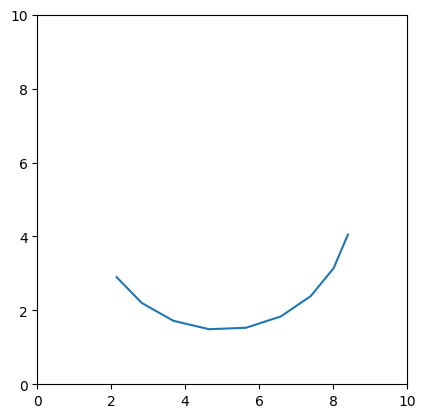

In [169]:
N=11 #0 to 50, do - 25 to centre 
T=60
K=11
circle = np.zeros((N,N))
#print(circular_field)
for i in range(N):
    for j in range(N):
        circle[i][j] = ((i-(N-1)/2)**2 + (j-(N-1)/2)**2)**(1/2)
circular_field = np.zeros((T,N,N))
for i in range(T):
    circular_field[i]= circle
positions = np.random.rand(1, 2)+2
concentrations = np.ones((1, 1))
#print(concentrations)
X = [i for i in range(K)]
#print(X)
Y = X
dt=1
num_steps=8
L=5
velocity_field = circular_field
#print(velocity_field)
phase_field = np.zeros(T*K*K).reshape((T, K, K))
gamma = 0
r=10
path = integrate_particles(positions, concentrations, velocity_field, X, Y, dt, num_steps, L, phase_field, gamma, r)

xcoords = [path[i][0][0] for i in range(num_steps+1)]
ycoords = [path[i][0][1] for i in range(num_steps+1)]
print(xcoords)


plt.plot(xcoords, ycoords)
plt.gca().set_aspect('equal')
plt.xlim(0, 10)
plt.ylim(0, 10)

plt.show()

In [189]:
import numpy as np
import matplotlib.pyplot as plt

#Dispersion relation
R_dim = 30e3
R_nondim = R_dim/300e3
beta_dim = 2e-12
beta_nondim = beta_dim * 86400 * 300e3

#Fourier harmonics
S = 10 #spectral radius
N = 41

def omega(k,l):
    return -beta_nondim * k / (k**2 + l**2 + R_nondim**-2)

P = 5 #radius of peak
H = 0.008 #height of peak (max amplitude)

def A(k,l):
  return H * np.exp(-0.5*(k**2+l**2-P**2)**2/(2*P**2))

k,l = np.linspace(-S,S,N),np.linspace(-S,S,N)
K,L = np.meshgrid(k,l)
phi = np.random.uniform(0,2*np.pi,size=(N,N))
omega_vals = omega(K,L)

def f(t,pos,gamma):
  #x_mod,y_mod = modulo_grid(*pos)
  dpsi_dx = np.real(np.sum(1j*K*A(K,L)*np.exp(1j*(K*x_mod + L*y_mod - omega_vals*t + phi))))
  dpsi_dy = np.real(np.sum(1j*L*A(K,L)*np.exp(1j*(K*x_mod + L*y_mod - omega_vals*t + phi))))

  dphi_dx = dpsi_dx
  dphi_dy = dpsi_dy

  u = gamma * dphi_dx - (1-gamma) * dpsi_dy
  v = gamma * dphi_dy + (1-gamma) * dpsi_dx

  return np.array([u,v])

#modify to make psi velocity field.
size_of_matrix = 21
Number_of_snapshots = 550 #and check every r days 
r=0.1
X = np.linspace(-np.pi, np.pi, size_of_matrix)
Y = X
psi = np.zeros((Number_of_snapshots, len(X), len(Y)), dtype = complex)
for a in range(Number_of_snapshots):
  for b in range(len(X)):
    for c in range(len(Y)):
      if not Number_of_snapshots*r % 10:       #so every 10 days we change phi
         np.random.seed(0)
         phi = np.random.uniform(0,2*np.pi,size=(N,N))
      psi[a,b,c] = np.sum(A(K,L)*np.exp(1j*(K*X[b]+L*Y[c]-omega_vals*(a*r)+phi)))

#def diff_wrt_y(original_matrix): 
#    nt, nx, ny = original_matrix.shape
#    umatrix = np.copy(original_matrix)
#    for i in range(nt):
#        umatrix[i] = np.gradient(original_matrix[i], axis=1) 
    #print(umatrix)
#    return umatrix

#negdpsidy= -1*diff_wrt_y(psi)
#test=0
#for a in range(Number_of_snapshots):
#  for b in range(len(X)):
#    for c in range(len(Y)):
#       test+=np.real(negdpsidy[a,b,c])
#print(test/(51*51*81))

In [193]:
positions = np.random.rand(20, 2)*2*np.pi
concentrations = np.ones((1, 1))
X=np.linspace(0, 2*np.pi, size_of_matrix)
Y=X
dt=0.5
num_steps=100
L=np.pi
velocity_field = psi
phase_field = psi
gamma = 0.0
#print(positions)
path = integrate_particles(positions, concentrations, velocity_field, X, Y, dt, num_steps, L, phase_field, gamma, r)

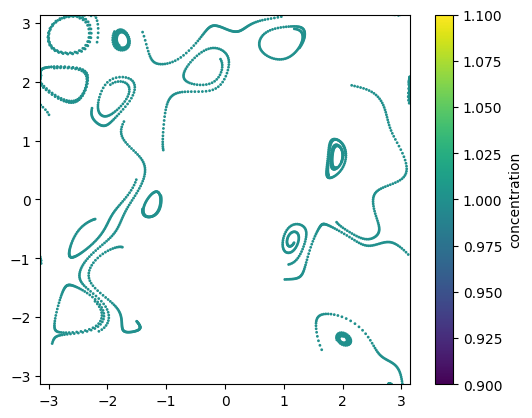

In [247]:

#print(path)
#fig, ax = plt.subplots()

#plt.scatter(xcoords, ycoords ,s=4)
#scatters = []
fig, ax = plt.subplots()

#for i in range(len(positions)):
#    scatter = ax.scatter([path[j][i][0]-np.pi for j in range(num_steps+1)],[path[j][i][1]-np.pi for j in range(num_steps+1)], 
#                         s=1, c=[path[j][i][2] for j in range(num_steps+1)], cmap='viridis')
    #if i==1:
        #fig.colorbar(scatters[0], ax=ax, label = 'Concentration') 
    #scatters.append(scatter)
xcoords = []
ycoords = []
c = []
for i in range(len(positions)):
    xcoords= xcoords + [path[j][i][0]-np.pi for j in range(num_steps+1)]  
    ycoords = ycoords + [path[j][i][1]-np.pi for j in range(num_steps+1)]
    c = c + [path[j][i][2] for j in range(num_steps+1)]

#print((xcoords))
#print((ycoords))
#print(len(c))
plt.scatter(xcoords, ycoords, c=c, s=1, cmap='viridis')
plt.colorbar(label='concentration')

plt.xlim(-np.pi, np.pi)
plt.ylim(-np.pi, np.pi)

plt.gca().set_aspect('equal')
plt.show()

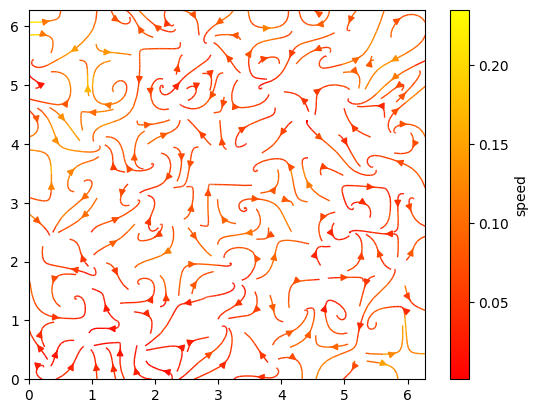

In [140]:
def diff_wrt_y(original_matrix): 
    nt, nx, ny = original_matrix.shape
    umatrix = np.copy(original_matrix)
    for i in range(nt):
        umatrix[i] = np.gradient(original_matrix[i], axis=1) 
    #print(umatrix)
    return umatrix

def diff_wrt_x(original_matrix): 
    nt, nx, ny = original_matrix.shape
    umatrix = np.copy(original_matrix)
    for i in range(nt):
        umatrix[i] = np.gradient(original_matrix[i], axis=0) 
    #print(umatrix)
    return umatrix

U = np.real(-1*diff_wrt_y(psi)[0])
V =np.real(diff_wrt_x(psi)[0])
#test=0
#for a in range(Number_of_snapshots):
#  for b in range(len(X)):
#    for c in range(len(Y)):
#       test+=np.real(negdpsidy[a,b,c])
#print(test/(51*51*81))




S=np.sqrt(U**2+V**2)

plt.streamplot(X,Y,U,V, color=S, linewidth=1, cmap = 'autumn')
plt.colorbar(label='speed')
plt.show()

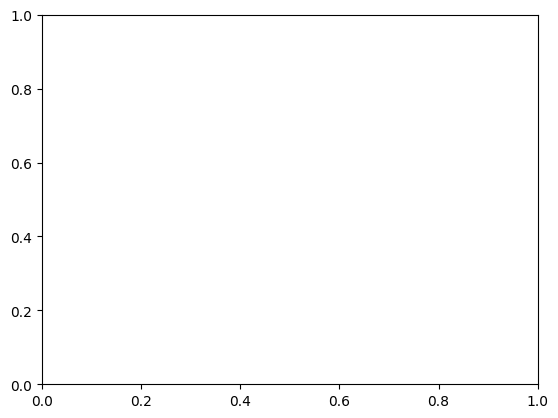

In [69]:
from matplotlib.animation import FuncAnimation
matplotlib.use('TkAgg')

fig, ax = plt.subplots()
def update(frame):
    # Clear the previous plot
    ax.clear()

    x_data = [path[frame][i][0]-np.pi for i in range(len(positions))]
    y_data = [path[frame][i][1]-np.pi for i in range(len(positions))]
    #conc = [path[frame][i][2]-np.pi for i in range(len(positions))]

    #plt.colorbar()
    plt.gca().set_aspect('equal')
    plt.scatter(x_data, y_data)

animation = FuncAnimation(fig, update, frames=num_steps, interval=100)
plt.show()